## Movimiento Browniano Geométrico - Tipo de Cambio

In [1]:
import pypyodbc
import pyodbc

import statsmodels.api as sm #Modelos estadistico y metodologías econometricas
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller #Pruebas de raíz unitaria ads,kpss,ers
from statsmodels.tsa.seasonal import seasonal_decompose #Análisis de estacionalidad

import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts

import sklearn as sk
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats.distributions import chi2
import seaborn as sns
import numpy as np  

import warnings
import itertools
import statsmodels.api as sm
plt.style.use('fivethirtyeight')
import requests
import pandas as pd
import urllib3

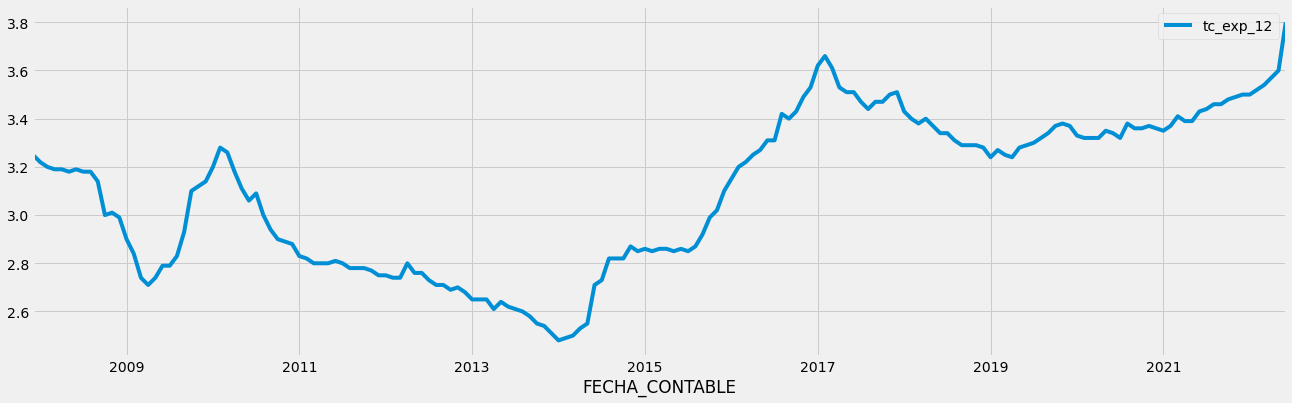

In [2]:
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

url = 'https://estadisticas.bcrp.gob.pe/estadisticas/series/mensuales/resultados/PD38049AM/html'
requests.post(url=url, verify=False)
html = requests.get(url,verify=False).content
df_list = pd.read_html(html)
DB_TC_E = df_list[-1] #este es el dataframe del banco
DB_TC_E['Fecha'] ='01'+ DB_TC_E['Fecha'].apply(str)
DB_TC_E.rename(columns={ DB_TC_E.columns[0]: "FECHA_CONTABLE" }, inplace = True)
DB_TC_E.rename(columns={ DB_TC_E.columns[1]: "tc_exp_12" }, inplace = True)
DB_TC_E['FECHA_CONTABLE'] = pd.date_range(start='12/1/2007', end='6/1/2022', freq='MS')
DB_TC_E.set_index('FECHA_CONTABLE', inplace =True)
DB_TC_E.plot(figsize=(20, 6));

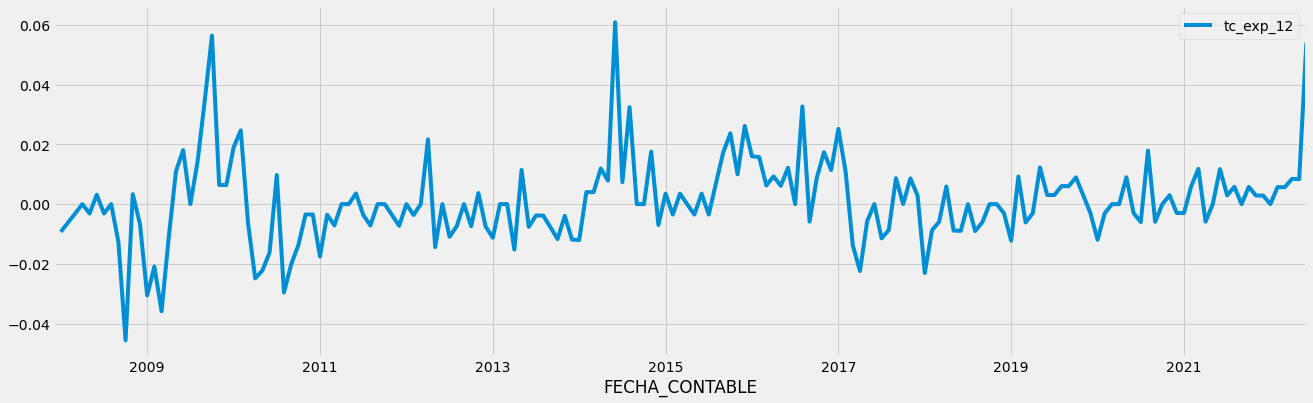

In [3]:
log_returns = np.log(1 + DB_TC_E.pct_change())
log_returns.plot(figsize=(20, 6));

In [4]:
base=DB_TC_E.reset_index()
base

,FECHA_CONTABLE,tc_exp_12
0,2007-12-01,3.25
1,2008-01-01,3.22
2,2008-02-01,3.20
3,2008-03-01,3.19
4,2008-04-01,3.19
...,...,...
170,2022-02-01,3.52
171,2022-03-01,3.54
172,2022-04-01,3.57
173,2022-05-01,3.60


## Definición de Parámetros

In [5]:
So = base.loc[base.shape[0] - 1, 'tc_exp_12']
end_date = '2022-06-01'
pred_end_date = '2023-06-01' 
n_of_wkdays = pd.date_range(start = pd.to_datetime(end_date, 
                 format = "%Y-%m-%d") + pd.Timedelta('1 days'), 
                 end = pd.to_datetime(pred_end_date, 
                 format = "%Y-%m-%d")).to_series().map(lambda x: 
                 1 if x.isoweekday() in range(1,6) else 0).sum()
T=n_of_wkdays
N = 12
dt = T/N
t = np.arange(1, int(N) + 1)
returns = (base.loc[1:, 'tc_exp_12'] - \
          base.shift(1).loc[1:, 'tc_exp_12']) / \
          base.shift(1).loc[1:, 'tc_exp_12']
mu = np.mean(returns)
sigma = np.std(returns)

##### Creando el parámetro browniano $ B_{t} $ : incremento


In [101]:
scen_size = 7 #CUÁNTOS ESCENARIOS QUIERES
b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
print(b)

{'1': array([-9.23522593e-01,  5.86181819e-01,  6.14065434e-01,  1.99387531e+00,
        8.42137070e-01, -4.47528071e-05, -1.37585197e-01, -6.02085258e-01,
       -1.15032518e+00, -3.31599384e-01, -4.57606175e-01, -1.73773752e+00]), '2': array([ 0.7346866 , -0.18043196, -0.4157149 ,  0.19718724, -0.62222125,
       -0.36008785, -0.59716845, -0.87211138,  0.07281902,  0.25205984,
       -1.16574701,  1.05818336]), '3': array([-1.40178754,  2.73478307,  0.44331189,  0.8422711 , -0.07011021,
       -1.03268905, -0.56022731,  0.92413165,  1.93595882,  0.88019206,
        0.61018862,  0.8848248 ]), '4': array([-0.04873067, -1.31014194, -0.60500489,  1.14359805, -0.63630917,
       -1.94108713,  1.16093092, -0.91109705,  0.81320053,  0.67948635,
        0.13409372,  0.2391459 ]), '5': array([-0.90134857, -0.06144768, -0.38129663,  0.83376979,  1.60693286,
       -1.27328276,  0.46566424, -0.5395533 ,  0.50179251,  0.30620991,
        0.9711339 ,  1.66638248]), '6': array([ 0.57948896,  0.732

##### Creando la trayectoria browniana $ B_{t} $

In [102]:
W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}
print(W)

{'1': array([-0.92352259, -0.33734077,  0.27672466,  2.27059997,  3.11273704,
        3.11269229,  2.97510709,  2.37302184,  1.22269666,  0.89109727,
        0.4334911 , -1.30424643]), '2': array([ 0.7346866 ,  0.55425464,  0.13853975,  0.33572698, -0.28649427,
       -0.64658212, -1.24375057, -2.11586195, -2.04304293, -1.79098309,
       -2.9567301 , -1.89854674]), '3': array([-1.40178754,  1.33299553,  1.77630742,  2.61857851,  2.5484683 ,
        1.51577925,  0.95555194,  1.8796836 ,  3.81564241,  4.69583448,
        5.30602309,  6.19084789]), '4': array([-0.04873067, -1.35887261, -1.9638775 , -0.82027944, -1.45658862,
       -3.39767575, -2.23674483, -3.14784188, -2.33464135, -1.655155  ,
       -1.52106129, -1.28191538]), '5': array([-0.90134857, -0.96279625, -1.34409288, -0.51032309,  1.09660977,
       -0.17667299,  0.28899125, -0.25056205,  0.25123046,  0.55744037,
        1.52857427,  3.19495676]), '6': array([0.57948896, 1.31192827, 0.73905649, 3.00332423, 4.07507074,
       

## Definición de $ S_{t} $

$$ S_{t}=S_{0}e^{(drift_{t}+difussion_{t})} $$

$$ S_{t}=S_{0}e^{\displaystyle \Bigg((\mu - \frac{1}2 \sigma^{2})t_{t}+\sigma W_{t}\Bigg)} $$

##### Parte determinística

In [103]:
drift = (mu - 0.5 * sigma**2) * t   
print("drift:\n", drift)

drift:
 [-0.25360879 -0.50721758 -0.76082637 -1.01443515 -1.26804394 -1.52165273
 -1.77526152 -2.02887031 -2.2824791  -2.53608788 -2.78969667 -3.04330546]


##### Parte browniana (aleatoria)

In [104]:
diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}
print("diffusion:\n", diffusion)

diffusion:
 {'1': array([-0.7291153 , -0.26632843,  0.21847238,  1.79262445,  2.45748639,
        2.45745105,  2.3488284 ,  1.87348587,  0.96531135,  0.70351571,
        0.3422385 , -1.02969438]), '2': array([ 0.58003047,  0.43758057,  0.10937626,  0.26505435, -0.22618543,
       -0.51047253, -0.98193328, -1.67045975, -1.61296959, -1.41396992,
       -2.33431988, -1.49889075]), '3': array([-1.10670248,  1.05239161,  1.40238357,  2.06735132,  2.01199975,
        1.19669822,  0.75440227,  1.48399842,  3.01242577,  3.70733189,
        4.18907197,  4.88763561]), '4': array([-0.03847256, -1.07282141, -1.55046897, -0.64760548, -1.14996758,
       -2.6824437 , -1.76589602, -2.48520143, -1.84318471, -1.3067345 ,
       -1.20086835, -1.01206416]), '5': array([-0.71160905, -0.7601216 , -1.0611529 , -0.40289688,  0.86576654,
       -0.13948222,  0.22815678, -0.19781717,  0.19834487,  0.44009568,
        1.20679981,  2.52239833]), '6': array([0.4575029 , 1.03575915, 0.58348047, 2.37110566, 3.21724

##### Ecuación $S_{t}$ y predicción

In [105]:
S = np.array([So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)]) 
S = np.hstack((np.array([[So] for scen in range(scen_size)]), S))
print(S)

[[2.85262440e-01 1.06770910e-01 1.31612710e-01 1.65845332e-01
  6.21166333e-01 9.37158141e-01 7.27204639e-01 5.06222594e-01
  2.44209181e-01 7.64198018e-02 4.56424144e-02 2.46789692e-02
  4.85694558e-03]
 [2.85262440e-01 3.95373654e-01 2.66073501e-01 1.48704259e-01
  1.34831897e-01 6.40190201e-02 3.73855526e-02 1.81054826e-02
  7.05741999e-03 5.80059741e-03 5.49232569e-03 1.69790145e-03
  3.03804248e-03]
 [2.85262440e-01 7.31928934e-02 4.92051622e-01 5.41837860e-01
  8.17561205e-01 6.00261508e-01 2.06119291e-01 1.02775844e-01
  1.65428273e-01 5.91910992e-01 9.20257571e-01 1.15607381e+00
  1.80396039e+00]
 [2.85262440e-01 2.13007687e-01 5.87546686e-02 2.82788523e-02
  5.41289393e-02 2.54164874e-02 4.26018746e-03 8.26683772e-03
  3.12469868e-03 4.60777820e-03 6.11403661e-03 5.27429263e-03
  4.94333387e-03]
 [2.85262440e-01 1.08656525e-01 8.03241576e-02 4.61284701e-02
  6.91361372e-02 1.90782149e-01 5.41779853e-02 6.07219263e-02
  3.07755986e-02 3.54908662e-02 3.50725016e-02 5.85869944e-0

##### Visualización

In [106]:
y=np.transpose(S)
df = pd.DataFrame(y)
df['FECHA_CONTABLE'] = pd.date_range(start='6/1/2022', end='6/1/2023', freq='MS')
df.set_index('FECHA_CONTABLE', inplace =True)
df

,0,1,2,3,4,5,6
FECHA_CONTABLE,,,,,,,
2022-06-01,0.285262,0.285262,0.285262,0.285262,0.285262,0.285262,0.285262
2022-07-01,0.106771,0.395374,0.073193,0.213008,0.108657,0.349780,0.262019
2022-08-01,0.131613,0.266074,0.492052,0.058755,0.080324,0.483935,0.130963
2022-09-01,0.165845,0.148704,0.541838,0.028279,0.046128,0.238904,0.096322
2022-10-01,0.621166,0.134832,0.817561,0.054129,0.069136,1.107743,0.136111
2022-11-01,0.937158,0.064019,0.600262,0.025416,0.190782,2.003415,0.188501
2022-12-01,0.727205,0.037386,0.206119,0.004260,0.054178,4.131101,0.136475
2023-01-01,0.506223,0.018105,0.102776,0.008267,0.060722,5.249334,0.136692
2023-02-01,0.244209,0.007057,0.165428,0.003125,0.030776,4.898835,0.112202


In [107]:

pd.options.plotting.backend = "plotly"
fig = df.plot(labels={'value': 'Tipo de Cambio','FECHA_CONTABLE': 'Fecha'}, title='Escenarios del TC a un año',template='plotly_dark')
fig.update_layout(showlegend=False)

fig.show()

In [108]:
df1 =df.copy()
df1['mean'] = df.mean(axis=1)
df1['16_per'] = df1.apply(lambda x: np.percentile(x, 16), axis=1)
df1['84_per'] = df1.apply(lambda x: np.percentile(x, 84), axis=1)
df1

,0,1,2,3,4,5,6,mean,16_per,84_per
FECHA_CONTABLE,,,,,,,,,,
2022-06-01,0.285262,0.285262,0.285262,0.285262,0.285262,0.285262,0.285262,0.285262,0.285262,0.285262
2022-07-01,0.106771,0.395374,0.073193,0.213008,0.108657,0.349780,0.262019,0.215543,0.106997,0.325207
2022-08-01,0.131613,0.266074,0.492052,0.058755,0.080324,0.483935,0.130963,0.234816,0.086401,0.422934
2022-09-01,0.165845,0.148704,0.541838,0.028279,0.046128,0.238904,0.096322,0.180860,0.052152,0.222652
2022-10-01,0.621166,0.134832,0.817561,0.054129,0.069136,1.107743,0.136111,0.420097,0.077020,0.762571
2022-11-01,0.937158,0.064019,0.600262,0.025416,0.190782,2.003415,0.188501,0.572793,0.078957,0.842827
2022-12-01,0.727205,0.037386,0.206119,0.004260,0.054178,4.131101,0.136475,0.756675,0.039401,0.748423
2023-01-01,0.506223,0.018105,0.102776,0.008267,0.060722,5.249334,0.136692,0.868874,0.023219,0.767332
2023-02-01,0.244209,0.007057,0.165428,0.003125,0.030776,4.898835,0.112202,0.780233,0.009904,0.630146


In [14]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=df1.index, y=df1['84_per'],
    fill=None,
    mode='lines',
    line_color='rgb(184, 247, 212)',
    ))
fig.add_trace(go.Scatter(
    x=df1.index,
    y=df1['16_per'],
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='rgb(184, 247, 212)'))
fig.add_trace(go.Scatter(x=df1.index, y=df1['mean'],
    fill=None,
    mode='lines',
    line_color='yellow',
    ))

fig.update_layout(title="Mediana del TC y Percentil 16 y 84 - Predicción",
    xaxis_title="Fecha",
    yaxis_title="Tipo de Cambio",showlegend=False,template='plotly_dark')

fig.show()

$$
S_t = S_{t-1} \cdot e^{\displaystyle \Bigg((r - 0.5 \cdot \sigma^{2}) \cdot delta_t + \sigma \cdot delta_t^{0.5} \cdot Z_t\Bigg)}
$$

### INFLACIÓN EDUCATIVA

In [25]:
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

url = 'https://estadisticas.bcrp.gob.pe/estadisticas/series/mensuales/resultados/PN01303PM/html'
requests.post(url=url, verify=False)
html = requests.get(url,verify=False).content
df_list = pd.read_html(html)
DB_INF = df_list[-1] #este es el dataframe del banco
DB_INF['Fecha'] ='01'+ DB_INF['Fecha'].apply(str)
DB_INF.rename(columns={ DB_INF.columns[0]: "FECHA_CONTABLE" }, inplace = True)
DB_INF.rename(columns={ DB_INF.columns[1]: "inflation" }, inplace = True)
DB_INF['FECHA_CONTABLE'] = pd.date_range(start='2/1/1992', end='6/1/2021', freq='MS')
DB_INF.set_index('FECHA_CONTABLE', inplace =True)
DB_INF.plot()


In [ ]:
base1=DB_INF.reset_index()
base1.to_csv(r'C:\Users\Leonela\Documents\0-Inversiones\inflation.csv', sep=';', encoding='iso-8859-1',index=False)

In [38]:
###
base2 = pd.read_csv (r"C:\Users\Leonela\Documents\0-Inversiones\inflation_sa.csv",sep = ";" ,encoding = "latin1")
base2

,FECHA_CONTABLE,inflation
0,Feb-92,3.924825
1,Mar-92,3.908494
2,Abr-92,24.391100
3,May-92,3.913481
4,Jun-92,3.816726
...,...,...
348,Feb-21,0.127798
349,Mar-21,0.094936
350,Abr-21,0.129150
351,May-21,0.121145


In [72]:
So2 = base2.loc[base2.shape[0] - 1, 'inflation']
end_date2 = '2021-06-01'
pred_end_date2 = '2022-06-01' 
n_of_wkdays2 = pd.date_range(start = pd.to_datetime(end_date2, 
                 format = "%Y-%m-%d") + pd.Timedelta('1 days'), 
                 end = pd.to_datetime(pred_end_date2, 
                 format = "%Y-%m-%d")).to_series().map(lambda x: 
                 1 if x.isoweekday() in range(1,6) else 0).sum()
T2=n_of_wkdays2
N2 = 12
dt2 = T2/N2
t2 = np.arange(1, int(N2) + 1)
returns2 = (base2.loc[1:, 'inflation'] - \
          base2.shift(1).loc[1:, 'inflation']) / \
          base2.shift(1).loc[1:, 'inflation']
mu2 = np.mean(returns2)
sigma2 = np.std(returns2)

In [90]:
scen_size2 = 6 #CUÁNTOS ESCENARIOS QUIERES
b2 = {str(scen2): np.random.normal(0, 1, int(N2)) for scen2 in range(1, scen_size2 + 1)}
print(b2)

{'1': array([ 0.05682759, -0.91958208, -0.8167377 , -0.58360261,  0.73675867,
        0.30021153, -2.30969428,  0.34264355, -0.05210996,  0.57375965,
        0.10074059, -0.30483163]), '2': array([ 1.16532697,  0.01160512,  1.68840371,  0.1364625 , -0.14386007,
       -0.85472224, -1.32146101,  0.72543809,  0.84220799,  1.17785652,
       -0.4687656 , -1.06925134]), '3': array([ 1.04360892,  1.1718608 ,  0.2416724 , -0.13785251, -0.60381272,
        0.66472748,  0.30965888,  0.6704023 ,  0.23680137,  0.39399371,
        0.00595632, -2.33744446]), '4': array([ 2.07890963, -0.25366909,  0.55113158, -0.30646891,  1.24013701,
       -0.10017718,  0.27000004,  0.31189504,  1.34053563, -0.92796337,
        0.22109625,  0.48746355]), '5': array([-1.05570063, -0.82981432, -0.74040411,  0.46209679,  1.46764158,
       -0.58625456,  0.05244667,  1.11166999,  0.14687987,  0.25050567,
        0.69012744,  0.31134826]), '6': array([-1.24718135, -0.8649632 , -2.57825029, -1.8295247 , -0.49443223,
  

In [91]:
W2 = {str(scen2): b2[str(scen2)].cumsum() for scen2 in range(1, scen_size2 + 1)}
print(W2)

{'1': array([ 0.05682759, -0.86275449, -1.67949218, -2.26309479, -1.52633612,
       -1.22612459, -3.53581888, -3.19317532, -3.24528529, -2.67152563,
       -2.57078504, -2.87561667]), '2': array([1.16532697, 1.17693209, 2.8653358 , 3.00179831, 2.85793823,
       2.003216  , 0.68175499, 1.40719307, 2.24940106, 3.42725758,
       2.95849198, 1.88924064]), '3': array([1.04360892, 2.21546972, 2.45714211, 2.3192896 , 1.71547688,
       2.38020436, 2.68986324, 3.36026554, 3.5970669 , 3.99106061,
       3.99701693, 1.65957247]), '4': array([2.07890963, 1.82524054, 2.37637212, 2.06990321, 3.31004023,
       3.20986305, 3.47986309, 3.79175813, 5.13229376, 4.20433039,
       4.42542664, 4.91289019]), '5': array([-1.05570063, -1.88551495, -2.62591906, -2.16382227, -0.69618069,
       -1.28243525, -1.22998858, -0.11831859,  0.02856128,  0.27906694,
        0.96919438,  1.28054265]), '6': array([-1.24718135, -2.11214455, -4.69039484, -6.51991954, -7.01435177,
       -6.72932113, -5.58710969, -5.27

In [99]:
drift2 = (mu2 - 0.5 * sigma2**2) * t2   
print("drift2:\n", drift2)

drift2:
 [-0.25360879 -0.50721758 -0.76082637 -1.01443515 -1.26804394 -1.52165273
 -1.77526152 -2.02887031 -2.2824791  -2.53608788 -2.78969667 -3.04330546]


In [100]:
diffusion2 = {str(scen2): sigma2 * W[str(scen2)] for scen2 in range(1, scen_size2 + 1)}
print("diffusion2:\n", diffusion2)

KeyError: '6'

In [94]:
S2 = np.array([So2 * np.exp(drift2 + diffusion2[str(scen2)]) for scen2 in range(1, scen_size2 + 1)]) 
S2 = np.hstack((np.array([[So2] for scen2 in range(scen_size2)]), S2))
print(S2)

KeyError: '6'

In [78]:
y2=np.transpose(S2)
df2 = pd.DataFrame(y2)
df2['FECHA_CONTABLE'] = pd.date_range(start='6/1/2021', end='6/1/2022', freq='MS')
df2.set_index('FECHA_CONTABLE', inplace =True)
df2

,0,1,2,3,4
FECHA_CONTABLE,,,,,
2021-06-01,0.117817,0.117817,0.117817,0.117817,0.117817
2021-07-01,0.041363,0.019850,0.046624,0.072484,0.177719
2021-08-01,0.037034,0.030309,0.073397,0.052810,0.691925
2021-09-01,0.061305,0.009923,0.029537,0.055547,1.059400
2021-10-01,0.039001,0.006097,0.014882,0.035092,0.854184
2021-11-01,0.006935,0.016166,0.007156,0.014208,0.183322
2021-12-01,0.000577,0.011243,0.019801,0.015540,0.646925
2022-01-01,0.000907,0.012133,0.011038,0.009808,0.370225
2022-02-01,0.003624,0.002292,0.023627,0.003683,0.498183


In [79]:
pd.options.plotting.backend = "plotly"
fig2 = df2.plot(labels={'value': 'Inflation','FECHA_CONTABLE': 'Fecha'}, title='Escenarios del TC a un año',template='plotly_dark')
fig2.update_layout(showlegend=False)

fig2.show()